# Introduction

***Please, pay attention, that it shows the logic of training the model, but it doesn't include all needed pieces of code which is necessary to run it from top to bottom and reproduce the result.***

This notebook is about solving OCR (Optical Character Recognition) task.

Pay attention that this task is based on the previous result related to the Text detection task because if you know where the text is, it is extremely difficult to recognize it. As far as you may remember the output of the previous step included bounding boxes with the only line of text inside.

Thus, in dealing with the OCR task we want to get a part of an image inside a bounding box as an input and return a sequence of symbols (selected from a predefined alphabet).

In [ ]:
# set ipython widgets parameters

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

In [ ]:
# google drive connection

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# path to a repository with the provided additional code

repo_folder = '/content/drive/MyDrive/github/'

In [ ]:
# install requirements

reqs_path = repo_folder + 'IntelligentDocumentProcessing/requirements.txt '
!pip3 install -r {reqs_path}

In [ ]:
# connect to W&B

import wandb
wandb_key = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
wandb.login(key=wandb_key)

In [ ]:
# set a path to utilities

import sys
base_folder = repo_folder + 'Resources/OCR/'
sys.path.append(base_folder)

In [ ]:
# stabilize random seed

from utils import set_seed

set_seed(17)

Seed is set to  17


# Data

We're using data from Wikipedia articles, cleaning them, and splitting them into text lines.

There is a problem with finding datasets for less popular languages (such as Russian). That's why we're going to start with texts and then use them for making synthetic data (images).

The process of getting synthetic data can be split into three steps:
1. Getting texts from an appropriate dataset
2. Text rendering
3. Image augmentation


## Getting texts from the appropriate dataset

The task includes three subtasks:

1. Uploading texts of articles (in both English and Russian)
2. Split each text by dots in order to get sentences
3. Remove symbols that are not included in a selected alphabet

In [ ]:
from utils import make_sentences_from_wiki

punct = " !\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~«»№"
digit = "0123456789"
cr = "ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё"
latin = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

ru_alphabet = punct+digit+cr
en_alphabet = punct+digit+latin

ru_path = base_folder+'resources/wiki/ru'
all_ru_sentences = make_sentences_from_wiki(ru_path, ru_alphabet, 50)
en_path = base_folder+'resources/wiki/en'
all_en_sentences = make_sentences_from_wiki(en_path, en_alphabet, 50)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

## Text renderring

We need some fonts in order to generate images with texts.

In [ ]:
from pathlib import Path

FONTS = [str(font) for font in Path(base_folder+'resources/fonts/').glob('*.ttf')]

len(FONTS), FONTS

Renderring itself.

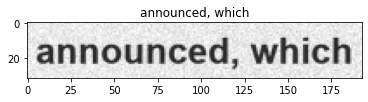

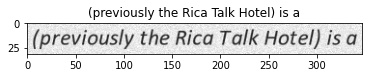

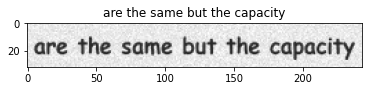

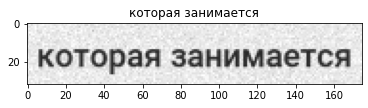

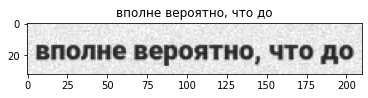

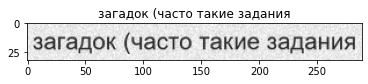

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from trdg.generators import GeneratorFromStrings


sample_words = list(np.random.choice(all_en_sentences, 3)) + list(np.random.choice(all_ru_sentences, 3))

generator = GeneratorFromStrings(
    sample_words,
    count=len(sample_words),
    fonts=FONTS,
    background_type=0 # 1 - white, 2 - patterns
)

for image, label in generator:
    plt.imshow(image)
    plt.title(label)
    plt.show()

### A function for text generation

The function below generates a syntetic dataset according to provided parameters:
- `all_texts` is a list of lines which represents ground truth texts
- `count` is an integer which is equal to a length of the dataset
- `result_images_path` is a path to directory to save generated images at
- `result_ann_path` is a path to a directory to save a file with markup

Dataset markup should look like this (and saved usingT CSV format):

| filename | text        |
| ---------| ----------- |
| 0.png    | text0       |
| 1.png    | text1       |
| 2.png    | text2       |

he function helps to generate 4 datasets: train/val datasets for Russian language (of size 15000 and 3000 images, respectively), and train/val for English language (sizes: 5000 and 1000).

```
data
└───ru_synth
│   │   train.csv
│   │   val.csv
│   │
│   └───train
│   │   │   image1.png
│   │   │   image2.png
│   │
│   └───val
│       │   image1.png
│       │   image2.png
└───en_synth
    │   train.csv
    │   val.csv
    │
    └───train
    │   │   image1.png
    │   │   image2.png
    │
    └───val
        │   image1.png
        │   image2.png
```

In [ ]:
from typing import List
import pandas as pd

def generate_dataset(
    all_texts: List[str],
    count: int,
    result_images_path: str,
    result_ann_path: str
) -> None:
    os.makedirs(result_images_path, exist_ok=True)
    selected_texts = np.random.choice(all_texts, count)
    generator = GeneratorFromStrings(
        selected_texts,
        count=count,
        fonts=FONTS,
        background_type=0 # 1 - white, 2 - patterns
    )
    labels = []
    for i, (text, (img, label)) in enumerate(zip(selected_texts, generator)):
        filename = f'image{i}.png'
        path = os.path.join(result_images_path, filename)
        img.save(path)
        labels.append({'filename': filename, 'text': text})
    pd.DataFrame(labels).to_csv(result_ann_path, index=False)

In [ ]:
import os
from sklearn.model_selection import train_test_split

ru_folder = '/content/drive/MyDrive/tmp/data/ru_synth/'
os.makedirs(ru_folder, exist_ok=True)
en_folder = '/content/drive/MyDrive/tmp/data/en_synth/'
os.makedirs(en_folder, exist_ok=True)

val_prc = 0.2
ru_train, ru_val = train_test_split(all_ru_sentences, test_size=val_prc)
en_train, en_val = train_test_split(all_en_sentences, test_size=val_prc)

generate_dataset(ru_train, 15000, ru_folder + 'train', ru_folder + 'train.csv')
generate_dataset(ru_val, 3000, ru_folder + 'val', ru_folder + 'val.csv')
generate_dataset(en_train, 5000, en_folder + 'train', en_folder + 'train.csv')
generate_dataset(en_val, 1000, en_folder + 'val', en_folder + 'val.csv')

"\ngenerate_dataset(ru_train, 15000, ru_folder + 'train', ru_folder + 'train.csv')\ngenerate_dataset(ru_val, 3000, ru_folder + 'val', ru_folder + 'val.csv')\ngenerate_dataset(en_train, 5000, en_folder + 'train', en_folder + 'train.csv')\ngenerate_dataset(en_val, 1000, en_folder + 'val', en_folder + 'val.csv')\n"

## Image augmentations

Before the moment, we've varied fonts only but in real life there are plenty of other characteristics which can be different. For example, color, background, texture, different defects, etc.

That's why augmentations are important and can significantly increase a model's robustness.

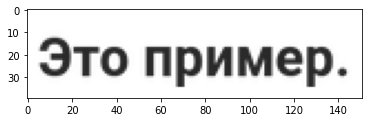

In [ ]:
import cv2

# initial image (example)
image = cv2.imread(base_folder+'images/example.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

### Standard augmentations from the Albumentation library

The following types of augmentations can be appropriate for the task:
* Shifting the image, scaling it, and rotation (`ShiftScaleRotate`)
* Changing colors (`HueSaturationValue`)
* Bluring (`GaussianBlur`)
* Compression (`ImageCompression`)
* Changing brightness and contrast (`RandomBrightnessContrast`)
* Turn to sepia (`ToSepia`)

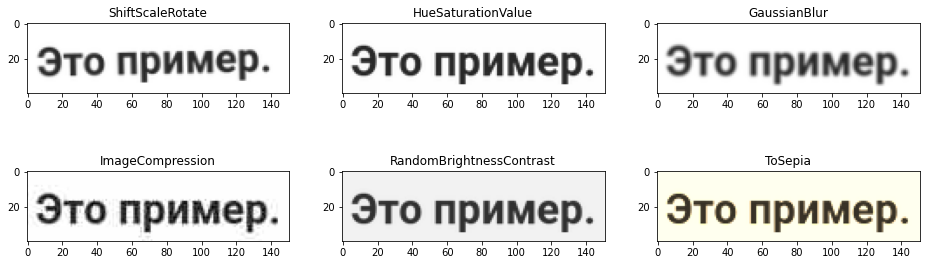

In [ ]:
import albumentations as A

augmentations = [
    A.ShiftScaleRotate(shift_limit=0.03, rotate_limit=2, interpolation=1, border_mode=1, p=0.3),
    A.HueSaturationValue(hue_shift_limit=50, sat_shift_limit=50, val_shift_limit=50, p=0.5),
    A.GaussianBlur(blur_limit=(3, 3), p=0.1),
    A.ImageCompression(quality_lower=10, quality_upper=50, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.3, brightness_by_max=False, p=0.1),
    A.ToSepia(p=0.15)
]

fig = plt.figure(figsize=(16, 5))
columns = np.ceil(len(augmentations) / 2).astype(int)
rows = 2
for i, aug in enumerate(augmentations):
    image_aug = aug(image=image, force_apply=True)['image']
    fig.add_subplot(rows, columns, i+1)
    plt.title(aug.__class__.__name__)
    plt.imshow(image_aug)
plt.show()

### Making custom augmentations

But along with the standard methods, you can want to make something specific for your task. For example, scanned document include a specific noise in form of black and white points (as it's demonstrated on the image below). Let's add it to our image calling `SaltAndPepper`.

<div>
<img src='https://i.imgur.com/jx8MPc9.png' width=500>
</div>

In [ ]:
from albumentations.core.transforms_interface import ImageOnlyTransform
from typing import Optional

class SaltAndPepper(ImageOnlyTransform):
    def __init__(self, p: float, max_salt_amount: float = 0.1, max_pepper_amount: float = 0.1):
        """
        Custom augmentation which adds white (salt) and black (pepper) noise to the provided image.

        Args:
            p: probability of using the augmentation
            max_salt_amount: maximum share of pixels which will become white
            max_pepper_amount: maximum share of pixels which will become black
        """
        super().__init__(p=p)
        assert 0 <= max_salt_amount <= 1
        self.max_salt_amount = max_salt_amount
        assert 0 <= max_pepper_amount <= 1
        self.max_pepper_amount = max_pepper_amount

    def apply(self, image: np.ndarray, **params) -> np.ndarray:
        """
        The main method for changing an image.

        Args:
            image: initial image
            **params:

        Returns:
            changed image
        """
        salt_amount = np.random.uniform(high=self.max_salt_amount)
        papper_amount = np.random.uniform(high=self.max_pepper_amount)
        image = self._salt(image, amount=salt_amount)
        image = self._pepper(image, amount=papper_amount)
        return image

    @staticmethod
    def _salt(image: np.ndarray, amount: float) -> np.ndarray:
        """
        Auxiliary method for making some pixels white

        Args:
            image: initial image
            amount: share of pixels which turn white

        Returns:
            changed image
        """
        noise = np.random.random(image.shape[:2])
        image[noise < amount] = 255
        return image

    @staticmethod
    def _pepper(image: np.ndarray, amount: float) -> np.ndarray:
        """
        Auxiliary method for making some pixels black.

        Args:
            image: initial image
            amount: share of pixels which will become black

        Returns:
            changed image
        """
        noise = np.random.random(image.shape[:2])
        image[noise < amount] = 0
        return image

In [ ]:
test_image = np.full((100, 100, 3), 128, dtype=np.uint8)
sandp = SaltAndPepper(
    p=1.0,
    max_salt_amount=0.05,
    max_pepper_amount=0.08,
)
tol = 0.01

salt_amount = 0.1
salted = sandp._salt(image=test_image, amount=salt_amount)
salt_amount_on_image = len(salted[salted == 255]) / len(salted.reshape(-1))

pepper_amount = 0.1
peppered = sandp._pepper(image=test_image, amount=pepper_amount)
pepper_amount_on_image = len(peppered[peppered == 0]) / len(peppered.reshape(-1))

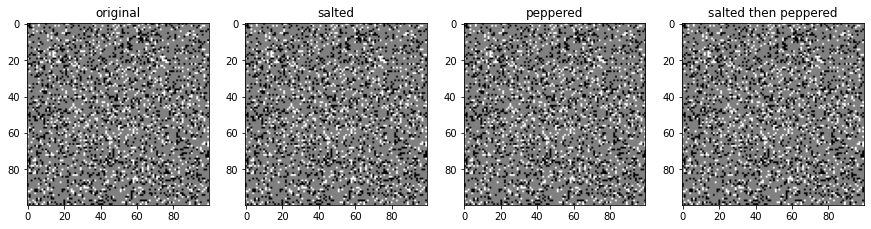

In [ ]:
# how it looks like

salted_then_peppered = sandp(image=test_image)['image']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
ax1.imshow(test_image, cmap='gray')
ax1.set_title('original')

ax2.imshow(salted, cmap='gray')
ax2.set_title('salted')

ax3.imshow(peppered, cmap='gray')
ax3.set_title('peppered')

ax4.imshow(salted_then_peppered, cmap='gray')
ax4.set_title('salted then peppered')

plt.show()

### Apply all augmentations simultaneously

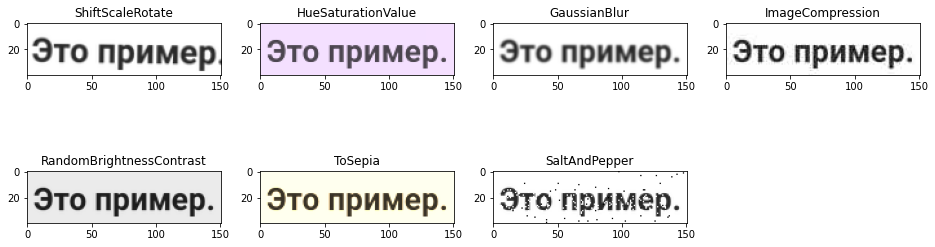

In [ ]:
augmentations.append(SaltAndPepper(p=0.7, max_salt_amount=0.25, max_pepper_amount=0.05))

fig = plt.figure(figsize=(16, 5))
columns = np.ceil(len(augmentations) / 2).astype(int)
rows = 2
for i, aug in enumerate(augmentations):
    image_aug = aug(image=image, force_apply=True)['image']
    fig.add_subplot(rows, columns, i+1)
    plt.title(aug.__class__.__name__)
    plt.imshow(image_aug)
plt.show()

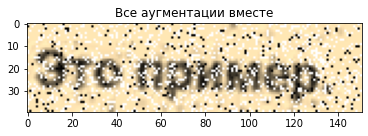

In [ ]:
# how it works
image_all_augs = A.Compose(augmentations)(image=image, force_apply=True)['image']
plt.imshow(image_all_augs)
plt.show()

## Tokenization

The dataset of images is ready but we need to prepare it to working with torch.

Neural networks prefer to work with numbers instead of text, that's why we need to vectorize our ground truth texts. We also want to be able to make a reverse operation getting letters (text) from a vector.

In [ ]:
punct = " !\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~«»№"
digit = "0123456789"
cr = "ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё"
latin = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
alphabet = punct + digit + cr + latin
alphabet

' !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~«»№0123456789ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяёABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

In [ ]:
import torch
from typing import List, Any, Tuple
from itertools import groupby

class TokenizerForCTC:
    def __init__(self, tokens: List[Any]):
        """
        Class for text transformation into a tensor appropriate for putting into CTCLoss and for tensor transformation into a text.

        Args:
            tokens: list of tokens (symbols) from a chosen alphabet
        """
        self.tokens = tokens
        self.blank_token = 0
        self.n_tokens = len(tokens) + 1
        self.char_idx = {}

        for i, char in enumerate(tokens):
          self.char_idx[char] = i + 1

    def encode(self, text: str) -> Tuple[torch.Tensor, int]:
        """
        Method for text transformation into a tensor appropriate for putting into CTCLoss.

        Args:
            text: initial text

        Returns:
            tokenized text in form of a tensor, length of the initial text
        """
        result = []

        for char in text:
          result.append([self.char_idx[char]])

        return torch.LongTensor(result), len(result)

    def decode(self, preds: List[Any]) -> str:
        """
        Method for tensor transformation into a text.

        Args:
            preds: model's predictions (represents the only line of symbols)

        Returns:
            model's confidence in form of probability; string of recognized symbols
        """
        remove_duplicates = [g for g, _ in groupby(preds)]
        remove_zeros = [g for g in remove_duplicates if g != 0]
        return ''.join([self.tokens[g-1] for g in remove_zeros])

In [ ]:
tokenizer = TokenizerForCTC(list(alphabet))

## Splitting data into datasets and making data loaders

In [ ]:
from utils import CsvAdapter

en_train_adapter = CsvAdapter(
    name='en_synth',
    images_dir='/content/drive/MyDrive/tmp/data/en_synth/train',
    csv_fpath='/content/drive/MyDrive/tmp/data/en_synth/train.csv',
    compute_length_by="label",
)
en_val_adapter = CsvAdapter(
    name='en_synth',
    images_dir='/content/drive/MyDrive/tmp/data/en_synth/val',
    csv_fpath='/content/drive/MyDrive/tmp/data/en_synth/val.csv',
    compute_length_by="label",
)

ru_train_adapter = CsvAdapter(
    name='ru_synth',
    images_dir='/content/drive/MyDrive/tmp/data/ru_synth/train',
    csv_fpath='/content/drive/MyDrive/tmp/data/ru_synth/train.csv',
    compute_length_by="label",
)
ru_val_adapter = CsvAdapter(
    name='ru_synth',
    images_dir='/content/drive/MyDrive/tmp/data/ru_synth/val',
    csv_fpath='/content/drive/MyDrive/tmp/data/ru_synth/val.csv',
    compute_length_by="label",
)

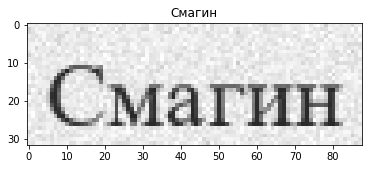

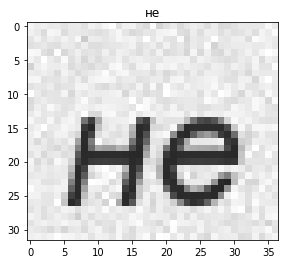

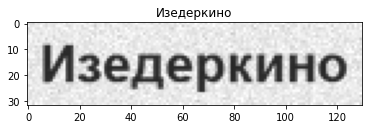

In [ ]:
# look at examples

for i in np.random.choice(len(ru_val_adapter), 3):
    item = ru_val_adapter.__getitem__(i)
    image_path = item.image_fpath
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = item.label
    plt.imshow(image)
    plt.title(label)
    plt.show()

It's interesting to look at statistics of image shapes.

In [ ]:
from utils import get_shapes_and_texts

train_texts, train_widths, train_heights = get_shapes_and_texts(ru_train_adapter)
val_texts, val_widths, val_heights = get_shapes_and_texts(ru_val_adapter)

In [ ]:
# height of all images is the same because we've generated data in such a way
np.unique(train_heights), np.unique(val_heights)

(array([32]), array([32]))

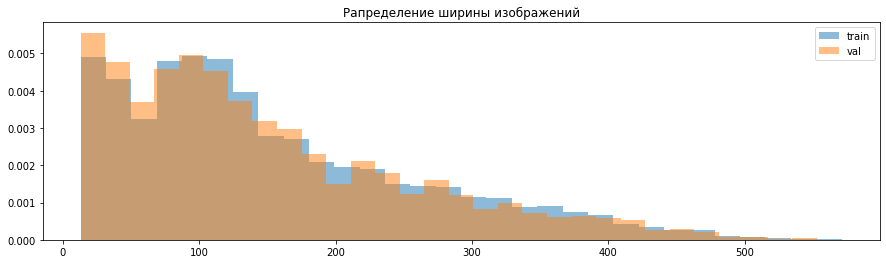

In [ ]:
plt.figure(figsize=(15, 4))
plt.hist(train_widths, density=True, bins=30, alpha=0.5, label='train')
plt.hist(val_widths, density=True, bins=30, alpha=0.5, label='val')
plt.title('Width distribution')
plt.legend()
plt.show()

It is a problem that images can be very wide (and very narrow). It means that we need to make their width the same in model training process in order to work with batches of images.

Then let's look at the distribution of lowcased symbol's frequency. Frequency belongs to the range [0, 1].

In [ ]:
from collections import Counter

def get_symbol_distribution(texts: List[int]) -> List[Tuple[str, float]]:
    string = ''.join(texts)
    n = len(string)
    cnt = Counter(string).most_common()
    return [(s, c/n) for s, c in cnt]

In [ ]:
sample_counts = dict(get_symbol_distribution(['abcd', 'bcde']))

true_top_symbols = {' ', 'а', 'е', 'и', 'о'}
train_counts = get_symbol_distribution(train_texts)
top_train_symbols = set(list(zip(*train_counts[:5]))[0])

val_counts = get_symbol_distribution(val_texts)
top_val_symbols = set(list(zip(*train_counts[:5]))[0])

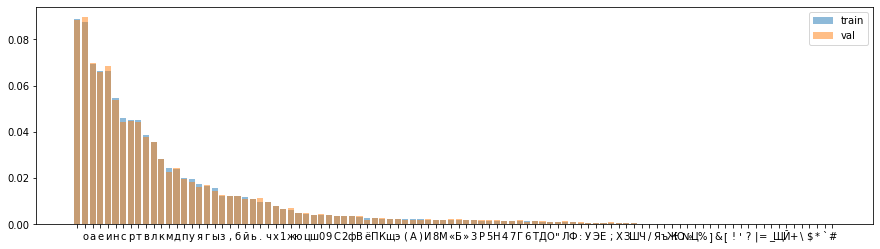

In [ ]:
plt.figure(figsize=(15, 4))
plt.bar(*list(zip(*train_counts)), alpha=0.5, label='train')
plt.bar(*list(zip(*val_counts)), alpha=0.5, label='val')
plt.legend()
plt.show()

The graph highlights another problem. There are less and more frequent symbols, and it's better to balance them while generating datasets.

### Dataset

Making datasets has several important characteristics:

1. It's possible to combine several datasets into one using explicit proportion. It can be useful in the case of mixing Cyrillic and Latin letters.

2. Stratification according to the length of an image. It's important to minimize paddings. Why it's important you can understand by looking at the following image.

<table><tr>
<td> 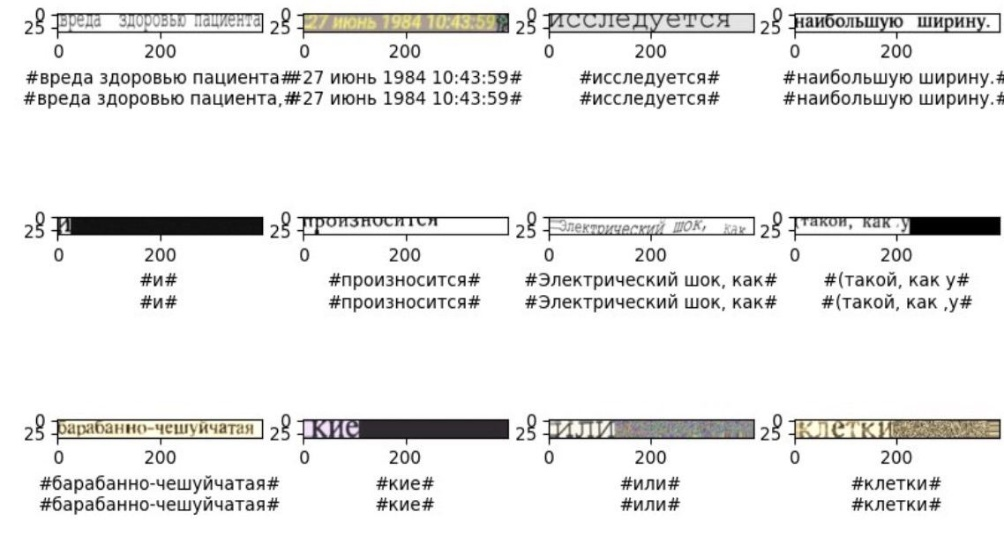 </td>
<td> 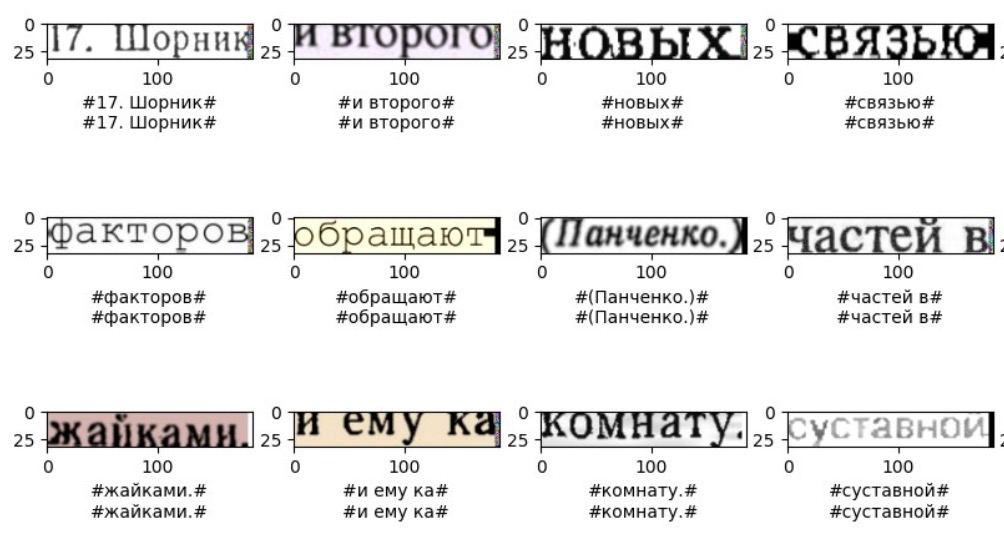 </td>
</tr></table>

### DataLoader

It's just a standard `torch.utils.data.DataLoader`.

In [ ]:
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(augmentations)

val_transform = A.NoOp()

post_transform = A.Compose([
    A.Normalize(
        mean=[0., 0., 0.],
        std=[1., 1., 1.],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])

In [ ]:
from utils import PadCollate
from utils import set_seed
from utils import worker_init_fn
from utils import OCRDataset

from torch.utils.data import DataLoader

train_dataset = OCRDataset(
    adapters=[(en_train_adapter, 0.3), (ru_train_adapter, 0.7)],
    transforms=train_transform,
    post_transforms=post_transform,
    tokenizer=tokenizer,
    epoch_size=5000,
    sort_by_length=True,
    target_height=32,
    max_width=1024,
)

val_dataset = OCRDataset(
    adapters=[(en_val_adapter, 0.3), (ru_val_adapter, 0.7)],
    transforms=val_transform,
    post_transforms=post_transform,
    tokenizer=tokenizer,
    epoch_size=2000,
    sort_by_length=True,
    target_height=32,
    max_width=1024,
)

# add paddings and return a preprocessed batch
collate = PadCollate()

set_seed(17)

num_workers = 0
train_batch_size = 128
train_dl = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=False,
    drop_last=True
)
val_batch_size = 64
val_dl = DataLoader(
    val_dataset,
    batch_size=val_batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=False,
    drop_last=False
)

Epoch size:  5000
Adapters
Adapter name:  en_synth
Adapter epoch ratio:  0.3
Adapter epoch size:  1500
Adapter name:  ru_synth
Adapter epoch ratio:  0.7
Adapter epoch size:  3500
Epoch size:  2000
Adapters
Adapter name:  en_synth
Adapter epoch ratio:  0.3
Adapter epoch size:  600
Adapter name:  ru_synth
Adapter epoch ratio:  0.7
Adapter epoch size:  1400
Seed is set to  17


# Loss function and metrics

When data are ready, we still need to determine what the model should optimize. We are going to use CAR and WAR metrics, and CTC Loss function.

## CTC Loss

In [ ]:
from torch.nn import CTCLoss
from torch.nn.modules.loss import _Loss

ctc_loss = CTCLoss(zero_infinity=True)  # zero_infinity=True is for robustness

## CAR and WAR metrics

Both metrics are based on the well-known [Levenstein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). The main idea is that it calculates a minimum number of actions that should be done in order to transform the second string into the first one. The available actions include D (delete), I (insert), and R (replace).

Metrics CAR (char accuracy rate) return average (normalized on the maximum length) Levenstein distance for all pairs (ground true text, recognized text), extracted from 1.

Metrics WAR is basically an accuracy. It is a share of fully coincided pairs (ground true text, recognized text) among the total number of the pairs.

In [ ]:
import Levenshtein

class Evaluator(object):
    """
    Class for calculating CAR (char accuracy rate) and WAR (word accuracy rate).
    """
    def __call__(self, gt_labels: List[str], pred_labels: List[str]):
        """
        Method for calculation of CAR and WAR.

        Args:
            gt_labels: ground true texts
            pred_labels: predicted texts

        Returns:
            dictionary with values of CAR and WAR
        """
        result = {
            'car': self._car(gt_labels, pred_labels),
            'war': self._war(gt_labels, pred_labels),
        }
        return result

    @staticmethod
    def _car(gt_labels: List[str], pred_labels: List[str]) -> float:
        """
        Method for CAR calculation.

        Args:
            gt_labels: ground true texts
            pred_labels: predicted texts

        Returns:
            CAR value
        """
        return 1 - np.mean([
            Levenshtein.distance(gt_text, pred_text) / max(len(gt_text), len(pred_text))
            for gt_text, pred_text in zip(gt_labels, pred_labels)
        ])

    @staticmethod
    def _war(gt_labels: List[str], pred_labels: List[str]) -> float:
        """
        Method for WAR calculation.

        Args:
            gt_labels: ground true texts
            pred_labels: predicted texts

        Returns:
            WAR value
        """
        return np.mean([
            int(gt == pred)
            for gt, pred in zip(gt_labels, pred_labels)
        ])

# Model

At the task we're training [CRNN (Convolutional Recurrent Neural Network](https://arxiv.org/abs/1507.05717)). Its architecture is following:

<img src="https://images4.russianblogs.com/922/df/df7f964dc5a09b659096b55b705c96f2.png">

So it works like this:

1. Pretrained convolutional backbone (ResNext in our case) returns a tensor ($batch\_size \times channels \times height \times width$).
2. The tensor's becomes flat. We're doing it using `GlobalMaxPooling` (max pooling along the selected dimentionality). It allows to get a new tensor of size $batch\_size \times channels \times width$.
3. Recurrent neural network returns an outcoming signal.

The outcome gets into CTC Loss. The model minimizes its value.

## Backbone: ResNext

In [ ]:
import torchvision
from torch import nn

raw_cnn = torchvision.models.resnext50_32x4d(pretrained=True)
all_layers = [raw_cnn.conv1, raw_cnn.bn1, raw_cnn.relu, raw_cnn.maxpool,
              raw_cnn.layer1, raw_cnn.layer2, raw_cnn.layer3, raw_cnn.layer4]
cnn = nn.Sequential(*all_layers)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

(32, 420, 3)


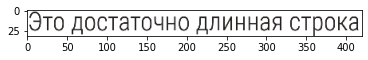

Ширина выхода из сети: 14
Длина текста на изображении: 29


In [ ]:
long_image = cv2.imread(base_folder+'images/long_image.png')
print(long_image.shape)
plt.imshow(long_image)
plt.show()

long_image_tensor = post_transform(image=long_image)['image'].float()
shape = cnn(long_image_tensor.unsqueeze(0)).shape
print(f'Width of output: {shape[-1]}')
text_on_image = 'Это достаточно длинная строка'
print(f'Length of the text on the image: {len(text_on_image)}')

Thus, you can see that the model's output is shorter than the number of symbols it needs to predict. There are two options for how to change it. Firstly, we can add a stride at the first layer ([how it works](https://arxiv.org/abs/1709.02054)) but then we'll need to change the rest of the network as well. Secondly, we can remove several layers at the end of the network in order to make the output wider.

Let's make the architecture dynamic.

In [ ]:
class DynamicResNext(nn.Module):
    def __init__(self, num_layers: int):
        super().__init__()
        raw_cnn = torchvision.models.resnext50_32x4d(pretrained=True)
        additional_layers = [raw_cnn.layer1, raw_cnn.layer2, raw_cnn.layer3, raw_cnn.layer4]
        all_layers = [raw_cnn.conv1, raw_cnn.bn1, raw_cnn.relu, raw_cnn.maxpool]
        all_layers += additional_layers[:num_layers]
        self.cnn = nn.Sequential(*all_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.cnn(x)

num_layers_outputs = np.array([105, 53, 27, 14])

num_layers = np.max([i+1 for i, num in enumerate(num_layers_outputs) if num >= len(text_on_image)])
num_layers

2

In [ ]:
resnext = DynamicResNext(num_layers)
out_width = resnext(long_image_tensor.unsqueeze(0)).shape[-1]
assert out_width > len(text_on_image), 'Output of the network is smaller than a number of synbols on the image.'

## Combine the backbone and a recurrent network

In [ ]:
from utils import BidirectionalLSTM
from utils import GlobalMaxPool2d

class ResnextCRNN(nn.Module):
    def __init__(
        self,
        num_classes: int,
        num_hidden: int,
        num_layers: int
    ):
        """
        Class that implements CRNN using RexNext as a backbone

        Args:
            num_classes: number of classed (alphabet size)
            num_hidden: number of features at the hidden RNN
        """
        super().__init__()
        self.cnn = nn.Sequential(
            DynamicResNext(num_layers),
            GlobalMaxPool2d()
        )
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, num_hidden, num_hidden),
            BidirectionalLSTM(num_hidden, num_hidden, num_classes)
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.cnn(x.float())
        x = x1.squeeze(2)
        x = x.permute(2, 0, 1)
        x = self.rnn(x)
        return x


In [ ]:
model = ResnextCRNN(num_hidden=256, num_classes=10, num_layers=num_layers)

input_tensor = torch.rand(
    32,  # batch size
    3,   # number of channels
    32,  # height
    500  # width
)
output_tensor = model(input_tensor)

# Training the model

## Lightning Module

In [ ]:
import pytorch_lightning as pl
import wandb

from torch import optim
from utils import draw_predictions

class CRNNRunner(pl.LightningModule):
    """
    The main class for training CRNN.
    """
    def __init__(self, tokenizer: TokenizerForCTC, loss: _Loss):
        super(CRNNRunner, self).__init__()

        self.model = ResnextCRNN(num_hidden=256, num_classes=tokenizer.n_tokens, num_layers=num_layers)
        self.evaluator = Evaluator()

        self.loss = loss

        self.draw_batch_idx = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch: Any, batch_idx: int) -> Any:
        images, raw_images, labels, targets, lengths = batch
        current_batch_size = images.shape[0]
        preds = self.forward(images)
        preds_size = torch.IntTensor([preds.size(0)] * current_batch_size)
        preds = preds.log_softmax(dim=2)
        loss = self.loss(preds, targets, preds_size, lengths)
        self.log("train_loss", loss.detach().cpu(), on_step=True, on_epoch=False)

        _, preds = preds.max(2)
        preds = preds.transpose(1, 0).detach().cpu().numpy()
        pred_labels = [tokenizer.decode(p) for p in preds]

        log_images_every_n_epoch = 5
        if self.current_epoch % log_images_every_n_epoch == 0 and batch_idx == self.draw_batch_idx:
            with torch.no_grad():
                train_preds = draw_predictions(raw_images, labels, pred_labels)
                if isinstance(self.logger, WandbLogger):
                    trainer.logger.experiment.log({"train_preds": wandb.Image(train_preds)})

        return loss

    def training_epoch_end(self, _: Any) -> None:
        """
        The method is called after the end of an epoch. It reloads data for the next epoch.
        """
        self.trainer.train_dataloader.dataset.datasets.reset_epoch()

    def validation_step(self, batch: Any, batch_idx: int) -> Any:
        images, raw_images, labels, targets, lengths = batch
        current_batch_size = images.shape[0]
        preds = self.forward(images)
        preds_size = torch.IntTensor([preds.size(0)] * current_batch_size)
        preds = preds.log_softmax(dim=2)
        loss = self.loss(preds, targets, preds_size, lengths)
        self.log("val_loss", loss.detach().cpu(), on_step=False)

        _, preds = preds.max(2)
        preds = preds.transpose(1, 0).detach().cpu().numpy()
        pred_labels = [tokenizer.decode(p) for p in preds]

        metrics = self.evaluator(labels, pred_labels)

        for m_name, m_value in metrics.items():
            self.log(f"val_{m_name}", m_value, on_step=False)

        log_images_every_n_epoch = 5
        if self.current_epoch % log_images_every_n_epoch == 0 and batch_idx == self.draw_batch_idx:
            with torch.no_grad():
                val_preds = draw_predictions(raw_images, labels, pred_labels)
                if isinstance(self.logger, WandbLogger):
                    trainer.logger.experiment.log({"val_preds": wandb.Image(val_preds)})

    def validation_epoch_end(self, _: Any) -> None:
        """
        The method runs after the end of validation. It chooses a random index of a batch for logging.
        """
        self.draw_batch_idx = np.random.randint(0, len(self.trainer.val_dataloaders[0]))

    def test_step(self, batch: Any, batch_idx: int) -> Any:
        self.validation_step(batch, batch_idx)

    def configure_optimizers(self) -> Tuple[List[Any], List[Any]]:
        optimizer = optim.AdamW(self.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0001)
        lr_scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer=optimizer,
            base_lr=0.0001,
            max_lr=0.001,
            step_size_up=2000,
            step_size_down=5000,
            mode="triangular",
            cycle_momentum=False,
        )
        scheduler = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1,
            "monitor": "val_loss",
        }
        print(lr_scheduler)
        print(optimizer)
        return [optimizer], [scheduler]

## Training

In [ ]:
import os

from datetime import datetime

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger


set_seed(18)

model = CRNNRunner(tokenizer, ctc_loss)

version = datetime.now().strftime("%Y%m%dT%H%M%S")

lr_logger = LearningRateMonitor()

logs_dir = "/content/drive/MyDrive/tmp/logs"
project_name = "sber-tr-course"
exp_name = f"second_hw_{version}"

cfg_save_dir = os.path.join(logs_dir, project_name, exp_name)

# save weights when the quality increased on a validation step
checkpoint_callback = ModelCheckpoint(
    dirpath=cfg_save_dir,
    filename='{epoch}_{val_war:.4f}',
    mode="max",
    monitor="val_war",
    save_top_k=1,
    verbose=True
)

Seed is set to  18


In [ ]:
os.environ['WANDB_API_KEY'] = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
logger = WandbLogger(
    save_dir=logs_dir,
    project=project_name,
    name=exp_name,
)

In [ ]:
trainer = Trainer(
    callbacks=[checkpoint_callback, lr_logger],
    logger=logger,
    gpus=[0],
    accumulate_grad_batches=1,
    min_epochs=1,
    max_epochs=200,
    #max_steps=2,
    gradient_clip_val=0.5,
    num_sanity_val_steps=3,
    check_val_every_n_epoch=1,
    fast_dev_run=False,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

### Quality estimation

In [ ]:
test_adapter = CsvAdapter(
    name='en_synth',
    images_dir='/content/drive/MyDrive/tmp/data/en_synth/val',
    csv_fpath='/content/drive/MyDrive/tmp/data/en_synth/val.csv',
    compute_length_by="label",  # label, image
    load_image=False
)
test_transform = A.NoOp()
test_dataset = OCRDataset(
    adapters=[(test_adapter, 1.0)],
    transforms=test_transform,
    post_transforms=post_transform,
    tokenizer=tokenizer,
    epoch_size=-1,
    sort_by_length=True,
    target_height=32,
    max_width=1024,
)

num_workers = 2
test_batch_size = 32

test_dl = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=False,
    drop_last=False
)

Epoch size:  -1
Adapters
Adapter name:  en_synth
Adapter epoch ratio:  1.0
Adapter epoch size:  1000


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_car            0.9653104664788874
        val_loss            0.1483495980501175
         val_war                   0.849
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


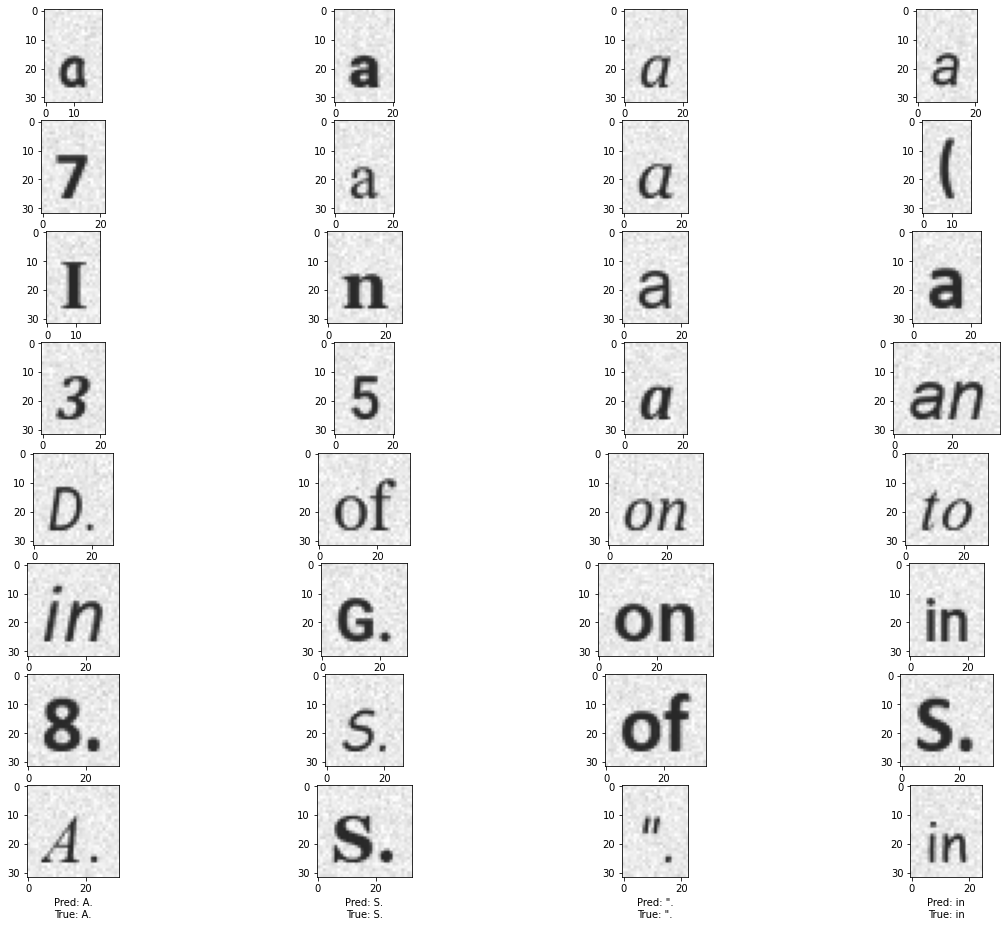

In [ ]:
ckpt_path = '/content/drive/MyDrive/tmp/logs/sber-tr-course/second_hw_20221108T101902/epoch=165_val_war=0.9400.ckpt'
model = CRNNRunner.load_from_checkpoint(ckpt_path, tokenizer=tokenizer, loss=ctc_loss)
_ = trainer.test(model=model, dataloaders=test_dl)

# Saving the model

In [ ]:
from typing import Type, Dict

def jit_save(
    checkpoint_path: str,
    jit_path: str,
    runner_class: Type[CRNNRunner],
    runner_kwargs: Dict[str, Any]
) -> None:
    model = runner_class.load_from_checkpoint(checkpoint_path, **runner_kwargs).model.eval()
    input_example = torch.rand(1, 3, 32, 256)
    torch.jit.save(torch.jit.trace(model, input_example), jit_path)

In [ ]:
checkpoint_path = ckpt_path
jit_path = f'/content/drive/MyDrive/models/model_tr.jit'
runner_kwargs = {'tokenizer': tokenizer, 'loss': ctc_loss}
jit_save(checkpoint_path, jit_path, CRNNRunner, runner_kwargs)

original_model = CRNNRunner.load_from_checkpoint(checkpoint_path, **runner_kwargs).model.eval()
saved_model = torch.jit.load(jit_path).eval()

# Inference

In [ ]:
from typing import Union

from albumentations import BasicTransform, Compose, OneOf

def inference(
    model: nn.Module,
    image: np.ndarray,
    transform: Union[BasicTransform, Compose, OneOf],
    tokenizer: TokenizerForCTC,
    device: str = 'cpu'
) -> str:
    """
    Method for inference.

    Args:
        model: the trained model
        image: an image in format np.ndarray
        transform: preprocessing to apply

    Returns:
        recognized text
    """
    # preprocessing
    image_changed = transform(image=image)['image']
    image_changed = torch.Tensor(image_changed[np.newaxis,:])
    # making predictions
    with torch.no_grad():
        preds = model(image_changed).to(device)
    # postprocessing
    preds = preds.log_softmax(dim=2)
    _, preds = preds.max(2)
    preds = preds.transpose(1, 0).detach().cpu().numpy()
    pred_labels = [tokenizer.decode(p) for p in preds]

    return ''.join(pred_labels)

In [ ]:
model = torch.jit.load('/content/drive/MyDrive/models/model_tr.jit')
model.eval()

image = cv2.imread(base_folder+"images/example.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

result = inference(model, image, post_transform, tokenizer)

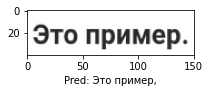

In [ ]:
# visualize the prediction
result = draw_predictions([image], predicted_texts=[result])
result.show()